# Versed plays in DraCor

In [1]:
import json
import requests

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

In [2]:
from lxml import etree

# we need this parameter to search in TEI-encoded files correctly
tei_ns = {'tei': 'http://www.tei-c.org/ns/1.0'}

In [3]:
# change the variable here to change the corpus you're working with
CORPUS = "ger"

## 1 &emsp; Getting data

Extracting all the plays from the DraCor API:

In [4]:
playnames = []
request_link = "https://dracor.org/api/corpora/{}".format(CORPUS)
response = requests.get(request_link)
if response:
    all_plays = response.json()["dramas"]
    for play in all_plays:
        playnames.append(play["name"])

In [5]:
def download_play_text(playname):
    """Uses DraCor API to download play text for further work.
    
    :arg playname (str) — play name to use in GET /tei query
    
    :returns text (str) - XML of the play, TEI-encoded
    """
    req_link = "https://dracor.org/api/corpora/{}/play/{}/tei".format(CORPUS, playname)
    text = requests.get(req_link).text
    return text

In [6]:
def calculate_p_l(text):
    """Calculates the amounts of <p> and <l> elements in a given play's
    XML document. If any of the values isn't present (say, there's no <l>
    in prose drama) it's assigned 0.
    
    :arg text (str) - TEI-encoded play
    
    :returns p_len (int)
    :returns l_len (int)
    """
    root = etree.fromstring(text)
    try:
        p_len = len(root.findall(".//tei:p", tei_ns))
    except:
        p_len = 0
    try:
        l_len = len(root.findall(".//tei:l", tei_ns))
    except:
        l_len = 0
    return p_len, l_len

Adding metadata:

In [7]:
def get_play_metadata_from_api(playname):
    """Fetch play metadata from DraCor API, including:
        play title,
        author's full name,
        normalized year
    In case the request returns with error code, returns a tuple of ("", "", 0).
    
    :arg playname - (str) play name to use in GET /play query.
    
    :returns title (str)
    :returns author (str)
    :returns year (int)
    """
    request_link = "https://dracor.org/api/corpora/{}/play/{}".format(CORPUS, playname)
    response = requests.get(request_link)
    if response.status_code == 200:
        response_json = json.loads(response.text)
        title = response_json["title"]
        author = response_json["author"]["name"]
        year = int(response_json["yearNormalized"])
    else:
        print("Couldn't retrieve metadata\n\t- play: {}\n\t- status code: {}".format(playname, response.status_code))
        print(request_link)
        title = ""
        author = ""
        year = 0
    return title, author, year

In [8]:
df_dict = {
    "name": [], 
    "author": [],
    "title": [],
    "year": [],
    "p": [], 
    "l": [], 
    "verse":[]
}

In [9]:
for playname in playnames:
    df_dict["name"] = playname
    playtext = download_play_text(playname)
    p, l = calculate_p_l(playtext)
    # verse or prose?
    df_dict["p"].append(p)
    df_dict["l"].append(l)
    if l > p:
        decision = True
    else:
        decision = False
    df_dict["verse"].append(decision)
    title, author, year = get_play_metadata_from_api(playname)
    df_dict["title"].append(title)
    df_dict["author"].append(author)
    df_dict["year"].append(year)

Converting to pandas dataframe:

In [10]:
df = pd.DataFrame.from_dict(df_dict)
df.head()

,name,author,title,year,p,l,verse
0,zschokke-abellino,"Alberti, Konrad",Im Suff,1890,369,193,False
1,zschokke-abellino,"Alberti, Konrad",Brot!,1888,807,12,False
2,zschokke-abellino,"Anzengruber, Ludwig",Der Pfarrer von Kirchfeld,1870,631,84,False
3,zschokke-abellino,"Anzengruber, Ludwig",Das vierte Gebot,1877,781,0,False
4,zschokke-abellino,"Anzengruber, Ludwig",Der Gwissenswurm,1874,640,124,False


## 2 &emsp; Figures and stats

General distribution:

In [11]:
df["verse"].value_counts()

False    284
True     190
Name: verse, dtype: int64

Type distribution by year:

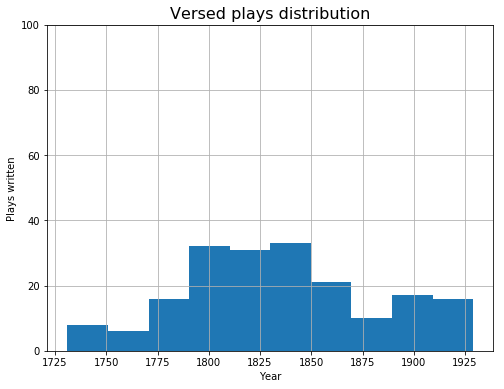

In [12]:
plt.figure(figsize=(8,6))
df[df["verse"] == True]["year"].hist()
# here and in the next cell:
# semi-colons at the end of the line to override some unwanted output
plt.title("Versed plays distribution", fontsize=16);
plt.xlabel("Year");
plt.ylim(0, 100);
plt.ylabel("Plays written");

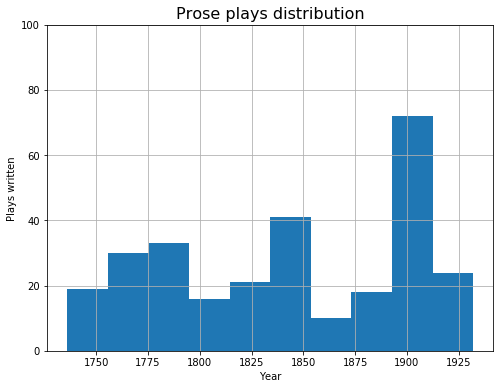

In [13]:
plt.figure(figsize=(8,6))
df[df["verse"] == False]["year"].hist();
plt.title("Prose plays distribution", fontsize=16);
plt.xlabel("Year");
plt.ylim(0, 100);
plt.ylabel("Plays written");

Authors who wrote versed drama, sorted by amount of plays:

In [14]:
df[df["verse"] == True]["author"].value_counts()

Hofmannsthal, Hugo von                      14
Goethe, Johann Wolfgang                     11
Wagner, Richard                             10
Grillparzer, Franz                           9
Hebbel, Friedrich                            9
Schiller, Friedrich                          8
Kleist, Heinrich von                         7
Immermann, Karl                              5
Neuber, Friederike Caroline                  4
Lortzing, Albert (Gustav)                    3
Eichendorff, Joseph von                      3
Günderode, Karoline von                      3
Mosenthal, Salomon Hermann von               3
Stephanie, Johann Gottlieb (der Jüngere)     3
Fouqué, Friedrich de la Motte                3
Arnim, Ludwig Achim von                      2
Heiseler, Henry von                          2
Schlegel, Johann Elias                       2
Wildenbruch, Ernst von                       2
Braun von Braunthal, Karl Johann             2
Widmann, Joseph Viktor                       2
Platen, Augus